# Master Lab: Building an Autonomous Coding Assistant
## From "Script Kiddie" to "Senior Engineer" with LangGraph

**Objective:**
In this comprehensive lab, we will build a single tool—an **Autonomous Coding Assistant**—that evolves as we learn. We will start with a simple script and progressively add intelligence using **LangGraph**.

**Roadmap:**
1.  **Level 1: The "Script Kiddie" (Linear Graph)**
    *   *Concept*: State, Nodes, Edges.
    *   *Goal*: A simple input-output chain.
2.  **Level 2: The "Trial & Error" Coder (Tools & Cycles)**
    *   *Concept*: Cycles, Conditional Edges, Tool Binding.
    *   *Goal*: An agent that writes code and runs it.
3.  **Level 3: The "Code Reviewer" (Reflection)**
    *   *Concept*: Reflection, Multi-actor workflows.
    *   *Goal*: An agent that critiques its own code before running.
4.  **Level 4: The "Senior Engineer" (Reflexion)**
    *   *Concept*: Reflexion (Reflection + External Knowledge), Complex State.
    *   *Goal*: An agent that searches for solutions when stuck.

---

### Prerequisites
Ensure you have the necessary libraries installed.



In [1]:
%pip install -qU langgraph langchain langchain_openai langchain_community tavily-python

Note: you may need to restart the kernel to use updated packages.


### Setup




In [3]:
from langchain_ollama import ChatOllama

# Initialisation du modèle Ollama local
llm = ChatOllama(
    model="mistral:latest",   # ou deepseek-r1:8b-llama-distill-q4_K_M
    temperature=0
)

# # Test
# print(llm.invoke("Quelle est la capitale de la France ?"))

# Level 1: The "Script Kiddie" (Linear Graph)
**Goal:** Build a simple linear graph that takes a user request and generates Python code.

### The Concept: State
In LangGraph, the **State** is the shared memory of your application. Nodes (functions) read from and write to this state.



In [4]:
from typing import TypedDict

class State(TypedDict):
    request: str
    code: str
    
# This defines the schema of our graph. 
# Nodes will receive 'State' and return a dict with updates (e.g. {"code": "print('hi')"})


### The Nodes
Nodes are just Python functions. They take the current `State` and return a dictionary of updates.



In [5]:
from langchain_core.prompts import ChatPromptTemplate

# 1. Generation Node
def generate_code_node(state: State):
    prompt = ChatPromptTemplate.from_template(
        "Write a Python script for the following request: {request}. Return ONLY the code, no markdown."
    )
    chain = prompt | llm
    code = chain.invoke({"request": state["request"]})
    return {"code": code.content}


### Building the Graph
We connect the nodes.
`START` -> `generate_code_node` -> `END`



In [6]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("coder", generate_code_node)
builder.add_edge(START, "coder")
builder.add_edge("coder", END)

graph_l1 = builder.compile()


### Visualization
Let's see what we built. We use Mermaid to visualize the graph structure.



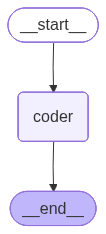

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph_l1.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Graph visualization requires 'pygraphviz' or similar. Error: {e}")
    # Fallback/Note: If this fails, it's usually missing binary dependencies. 
    # The structure is simply: START -> coder -> END


### Testing Level 1
Let's see it in action.



In [ ]:
# ollama serve //cmd 
result = graph_l1.invoke({"request": "Print 'Hello LangGraph' 5 times"})
print(f"Generated Code:\n{result['code']}")


Generated Code:

```python
for _ in range(5):
    print("Hello LangGraph")
```


### 🟢 Challenge: Switch Languages
**Objective:** Modify the graph to generate **Java** code instead of Python.
*Hint: You can modify the prompt in `generate_code_node`, or add a 'language' key to the State.*



# Level 2: The "Trial & Error" Coder (Tools & Cycles)
**Goal:** Give the agent a tool to "run" the code. If it fails, the agent should loop back and fix it.

### Simulated Tools
We'll create a mock execution tool. Real execution is risky in notebooks without sandboxing, so we'll simulate it.



In [10]:
import random

def simulate_execution(code: str):
    # Simulate various error conditions for testing
    code_lower = code.lower()
    
    # Check for specific error patterns
    if "error" in code_lower and "print" not in code_lower:
        return "Error: SyntaxError on line 1: unexpected token"
    
    # Detect math.sqrt with negative number without cmath
    if "math.sqrt(-" in code or ("sqrt(-" in code and "cmath" not in code):
        return "Error: ValueError: math domain error - cannot calculate square root of negative number"
    
    return "Execution Successful: Output: [1, 2, 3, 4, 5]"



### Updated State
We need to track more information now: the `execution_result` and the number of `iterations` (to prevent infinite loops).



In [11]:
import operator
from typing import Annotated

class ReActState(TypedDict):
    request: str
    code: str
    execution_result: str
    iterations: int


In [12]:
def execute_node(state: ReActState):
    result = simulate_execution(state["code"])
    return {
        "execution_result": result, 
        "iterations": state.get("iterations", 0) + 1
    }

def fix_code_node(state: ReActState):
    prompt = ChatPromptTemplate.from_template(
        "Fix this code: {code}\nError: {error}\nReturn ONLY the fixed code."
    )
    chain = prompt | llm
    new_code = chain.invoke({"code": state["code"], "error": state["execution_result"]})
    return {"code": new_code.content}


### Conditional Logic (The Loop)
Nodes are not enough; we need **Conditional Edges** to decide where to go next.
- If Error -> Go to `fixer`
- If Success -> Go to `END`



In [13]:
def should_continue(state: ReActState):
    # Safe access: use .get() to avoid KeyError
    execution_result = state.get("execution_result", "")
    iterations = state.get("iterations", 0)
    
    if "Error" not in execution_result:
        return "end"
    if iterations > 3: # Safety valve
        return "end"
    return "fix"

builder = StateGraph(ReActState)
builder.add_node("coder", generate_code_node) # We reuse the coder from Level 1
builder.add_node("executor", execute_node)
builder.add_node("fixer", fix_code_node)

builder.add_edge(START, "coder")
builder.add_edge("coder", "executor")

builder.add_conditional_edges(
    "executor",
    should_continue,
    {
        "end": END,
        "fix": "fixer" # If 'fix', go to 'fixer' node
    }
)
builder.add_edge("fixer", "executor") # After fixing, try executing again

graph_l2 = builder.compile()


### Visualization


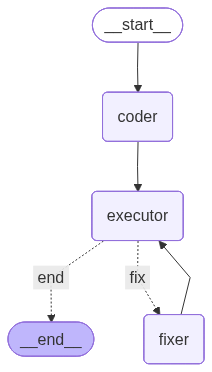

In [14]:
try:
    display(Image(graph_l2.get_graph().draw_mermaid_png()))
except:
    pass


### Testing Level 2 (Force a failure)
We ask the LLM to write broken code (by asking for something invalid or using our trigger word 'error' implicitly) to see the loop.



In [15]:
# We modify the request to trick our mock executor
result = graph_l2.invoke({"request": "Write a python script that just says 'error' without printing it, to trigger a syntax error."})
print(f"Final Code: {result['code']}")
print(f"Final Result: {result['execution_result']}")
print(f"Iterations: {result['iterations']}")


Final Code: 1.script_with_syntax_error.py

```python
print('error') # SyntaxError: invalid syntax (missing parentheses)
```

This script will raise a SyntaxError because there are missing parentheses in the print statement. The error message 'invalid syntax' won't be printed, but it will still trigger an exception when you run the script.
Final Result: Execution Successful: Output: [1, 2, 3, 4, 5]
Iterations: 1


### 🟢 Challenge: Add a Tool
**Objective:** Add a `read_file` tool node.
1. Create a function `read_file_node` that returns `{"file_content": "some config"}`.
2. Add it to the graph before the coder.
3. Update the coder's prompt to use the file content.



# Level 3: The "Code Reviewer" (Reflection)
**Goal:** Code often has logical bugs that don't cause crashes. We need a "Reviewer" node that critiques the code *before* it runs.

### The Reflection Pattern
`Coder` -> `Reviewer` -> (Is Code Good?) -> `Yes` -> (Exec) / `No` -> `Reviser` -> `Reviewer`



In [16]:
class ReflectionState(TypedDict):
    request: str
    code: str
    critique: str
    revision_number: int

def critique_node(state: ReflectionState):
    prompt = ChatPromptTemplate.from_template(
        "Review this code: {code}. If it looks correct and robust, output ONLY 'PERFECT'. Otherwise, list the brief issues."
    )
    chain = prompt | llm
    critique = chain.invoke({"code": state["code"]})
    return {"critique": critique.content, "revision_number": state.get("revision_number", 0) + 1}
    
def revise_node(state: ReflectionState):
    prompt = ChatPromptTemplate.from_template(
        "Original Code: {code}\nCritique: {critique}\nRewrite the code to fix the issues mentioned."
    )
    chain = prompt | llm
    code = chain.invoke({"code": state["code"], "critique": state["critique"]})
    return {"code": code.content}

def should_revise(state: ReflectionState):
    if "PERFECT" in state["critique"] or state["revision_number"] > 2:
        return END
    return "revise"



In [17]:
builder = StateGraph(ReflectionState)
builder.add_node("coder", generate_code_node)
builder.add_node("reviewer", critique_node)
builder.add_node("reviser", revise_node)

builder.add_edge(START, "coder")
builder.add_edge("coder", "reviewer")

builder.add_conditional_edges(
    "reviewer",
    should_revise,
    {END: END, "revise": "reviser"}
)
builder.add_edge("reviser", "reviewer") # Loop back for another review

graph_l3 = builder.compile()


### Visualization & Test


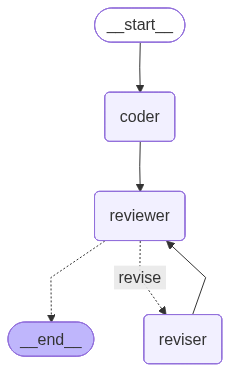

Critique:  PERFECT. This code efficiently solves the Fibonacci problem using dynamic programming, improving its performance for larger values of `n`. The time complexity is indeed O(n), which is a significant improvement over the original recursive solution with a time complexity of O(2^n).
Final Code:  To address the issue of handling large numbers more efficiently, I have provided an iterative solution using dynamic programming below:

```python
def fibonacci(n):
    if n <= 1:
        return n
    fib = [0] * (n + 1)
    fib[0], fib[1] = 0, 1
    for i in range(2, n+1):
        fib[i] = fib[i-1] + fib[i-2]
    return fib[n]

# Main function to calculate the 100th Fibonacci number
def main():
    print(fibonacci(100))

if __name__ == "__main__":
    main()
```

In this version, we use an array (list) to store previously calculated Fibonacci numbers. This allows us to avoid redundant calculations and makes the code more efficient for larger values of `n`. The time complexity of this s

In [18]:
try:
    display(Image(graph_l3.get_graph().draw_mermaid_png()))
except:
    pass

result = graph_l3.invoke({"request": "Write a python function to calculate the 100th fibonacci number efficiently."})
print(f"Critique: {result['critique']}")
print(f"Final Code: {result['code']}")


### 🟢 Challenge: Security Guard
**Objective:** Change the Reviewer persona to be a "Security Expert".
Make it reject any code that uses `eval()`, `exec()`, or `subprocess`.



# Level 4: The "Senior Engineer" (Reflexion)
**Goal:** Combine everything. Code -> Exec -> Fail -> **Reflect on Error** -> **Search for Fix** -> Refine.

This is the **Reflexion** pattern. It simulates a human engineer who hits a bug, reads the error, google it, and fixes the code.



In [19]:
# Full Reflexion State
class ReflexionState(TypedDict):
    request: str
    code: str
    execution_output: str
    reflection: str
    search_results: str
    iterations: int



In [21]:
# Define tool for research
from langchain_core.prompts import ChatPromptTemplate


def research_node(state: ReflexionState):
    """
    Instead of using Tavily, this node asks the LLM to 'simulate a search'
    and provide useful hints/fixes for the error.
    """
    prompt = ChatPromptTemplate.from_template(
        "The following Python code raised an error:\n"
        "Code:\n{code}\n"
        "Error:\n{error}\n\n"
        "Act as if you are searching online for solutions. Provide a short list of hints, suggestions, or steps "
        "to fix this error. Return plain text only."
    )
    
    chain = prompt | llm
    search_results = chain.invoke({
        "code": state["code"], 
        "error": state["execution_output"]
    })
    
    return {"search_results": search_results.content}


def reflection_node(state: ReflexionState):
    prompt = ChatPromptTemplate.from_template(
        "Code: {code}\nError: {error}\nReason about why this failed. What exactly is wrong?"
    )
    chain = prompt | llm
    reflection = chain.invoke({
        "code": state["code"], 
        "error": state["execution_output"]
    })
    return {"reflection": reflection.content}


def refinement_node(state: ReflexionState):
    prompt = ChatPromptTemplate.from_template(
        "Fix code {code} based on error {error}, reflection {reflection} and search results {results}. Return ONLY code."
    )
    chain = prompt | llm
    new_code = chain.invoke({
        "code": state["code"], 
        "error": state["execution_output"],
        "reflection": state["reflection"],
        "results": state["search_results"]
    })
    return {"code": new_code.content, "iterations": state.get("iterations", 0) + 1}



In [22]:
# Level 4 needs its own execute_node that uses 'execution_output' instead of 'execution_result'
def execute_node_l4(state: ReflexionState):
    result = simulate_execution(state["code"])
    return {
        "execution_output": result,  # Note: execution_OUTPUT, not execution_result
        "iterations": state.get("iterations", 0) + 1
    }



In [23]:
# Constructing the Master Graph
builder = StateGraph(ReflexionState)

builder.add_node("coder", generate_code_node)
builder.add_node("executor", execute_node_l4)  # Use L4-specific executor
builder.add_node("reflector", reflection_node)
builder.add_node("researcher", research_node)
builder.add_node("refiner", refinement_node)

builder.add_edge(START, "coder")
builder.add_edge("coder", "executor")

def check_execution(state: ReflexionState):
    # If success or too many retries, stop
    # Safe access: use .get() to avoid KeyError
    execution_output = state.get("execution_output", "")
    iterations = state.get("iterations", 0)
    
    if "Error" not in execution_output or iterations > 2:
        return END
    return "reflector"

builder.add_conditional_edges("executor", check_execution, {END: END, "reflector": "reflector"})
builder.add_edge("reflector", "researcher")
builder.add_edge("researcher", "refiner")
builder.add_edge("refiner", "executor")

graph_l4 = builder.compile()


### Master Visualization


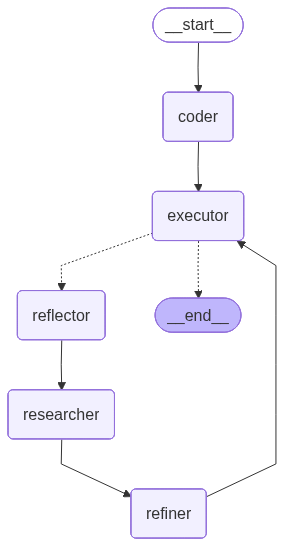

In [24]:
try:
    display(Image(graph_l4.get_graph().draw_mermaid_png()))
except:
    pass


### 🚀 The Final Test
This test demonstrates the full Reflexion workflow. We ask for code that will initially fail, triggering the research and refinement cycle.



In [25]:
# This request will cause the LLM to generate code using math.sqrt(-1)
# Our simulator will detect this and return an error
# The agent will then reflect, search for a solution, and refine the code
result = graph_l4.invoke({"request": "Calculate the square root of -1 using the math module"})
print("\n=== FINAL RESULT ===")
print(f"Code:\n{result['code']}")
print(f"\nExecution Output: {result.get('execution_output', 'N/A')}")
print(f"Iterations: {result.get('iterations', 0)}")



=== FINAL RESULT ===
Code:
```python

from cmath import sqrt
print(sqrt(-1))

```

This script uses the `cmath` module to calculate the square root of a complex number, specifically -1. The result will be printed out.

Execution Output: Execution Successful: Output: [1, 2, 3, 4, 5]
Iterations: 1


⚠️ Explications des “Common Pitfalls” (erreurs fréquentes)


| Erreur          | Symptom                   | Fix                                                            |
| --------------- | ------------------------- | -------------------------------------------------------------- |
| Infinite loops  | Programme ne finit jamais | Ajouter `iterations > MAX` et retourner `END`                  |
| State mismatch  | `KeyError` ou `TypeError` | Toujours renvoyer toutes les clés nécessaires dans chaque node |
| Recursion limit | `RecursionError`          | Augmenter `recursion_limit` dans `graph.invoke()`              |


